# Anomaly detection
___

### Imports and settings

In [2]:
import config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import (
    plot_predictions,
    classification_metrics_report, 
)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score

from imblearn.datasets import fetch_datasets
from imblearn.pipeline import (
    Pipeline, 
    make_pipeline,
)

In [3]:
PATH_DATA_PERF = config.PATH_DATA_PERF

SEED = config.SEED

DATASETS_LIST = config.DATASETS_LIST
EVAL_METRICS = config.EVAL_METRICS

CLF_DICT = config.CLF_DICT
PARAMS = config.PARAMS

UNDERSAMPLER_DICT = config.UNDERSAMPLER_DICT
OVERSAMPLER_DICT = config.OVERSAMPLER_DICT

### 1. Establishing baseline: naive approach

For each dataset in ```DATASETS_LIST``` 
- we train three models using their default hyperparameters 
- we compute the **average precision score** on the test set 
- finally, we choose the model with the highest score as the winner

In [4]:
for dataset in DATASETS_LIST:

    metrics_df = pd.DataFrame(columns=EVAL_METRICS, index=list(CLF_DICT.keys()))
    
    # Loading data
    data = fetch_datasets()[dataset]
    X = pd.DataFrame(data.data)
    y = pd.DataFrame(data.target, columns=["target"])

    # Data processing
    X.columns = [f"v{i}" for i in range(len(X.columns))]
    y["target"] = y["target"].map({-1:0, 1:1})

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

    # Scaling
    scaler = MinMaxScaler().fit(X_train)
    col_names = scaler.feature_names_in_

    X_train = pd.DataFrame(scaler.transform(X_train), columns=col_names, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=col_names, index=X_test.index)

    # Fitting models and computing metrics
    for model_name, model in CLF_DICT.items(): 
        model.fit(X_train, y_train.values.ravel())
        metrics_dict = classification_metrics_report(X_test, y_test, model)
        metrics_df.loc[model_name] = metrics_dict
    
    metrics_df['dataset'] = [dataset]*len(CLF_DICT)
    metrics_df.to_csv(f"{PATH_DATA_PERF}naive-supervised-{dataset}.csv")

c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
# Winner model for each dataset
# =============================

results = pd.concat([pd.read_csv(PATH_DATA_PERF + f) for f in [f"naive-supervised-{d}.csv" for d in DATASETS_LIST]])
results.rename(columns={"Unnamed: 0":"model"},inplace=True)

tmp = results.sort_values(["dataset","Average_Precision"], ascending=[True,False])
tmp["rank"] = tmp.groupby("dataset").cumcount()+1
tmp[tmp["rank"]==1].drop(columns="rank")   #.to_csv(f"{PATH_DATA_PERF}report-naive-supervised-{dataset}.csv")

,model,Accuracy,Precision,Recall,F1,ROC AUC,FN,TP,FP,TN,Average_Precision,dataset
1,randforest,0.9451,0.4725,0.5000,0.4859,0.9698,5.0,0.0,0.0,86.0,0.6267,arrhythmia
2,naivebayes,0.6912,0.6250,0.8279,0.5960,0.9696,0.0,7.0,21.0,40.0,0.6663,ecoli
0,logreg,0.9705,0.4852,0.5000,0.4925,0.9379,15.0,0.0,0.0,493.0,0.3888,ozone_level
1,randforest,0.9775,0.9593,0.8355,0.8865,0.9924,15.0,31.0,2.0,707.0,0.9340,thyroid_sick


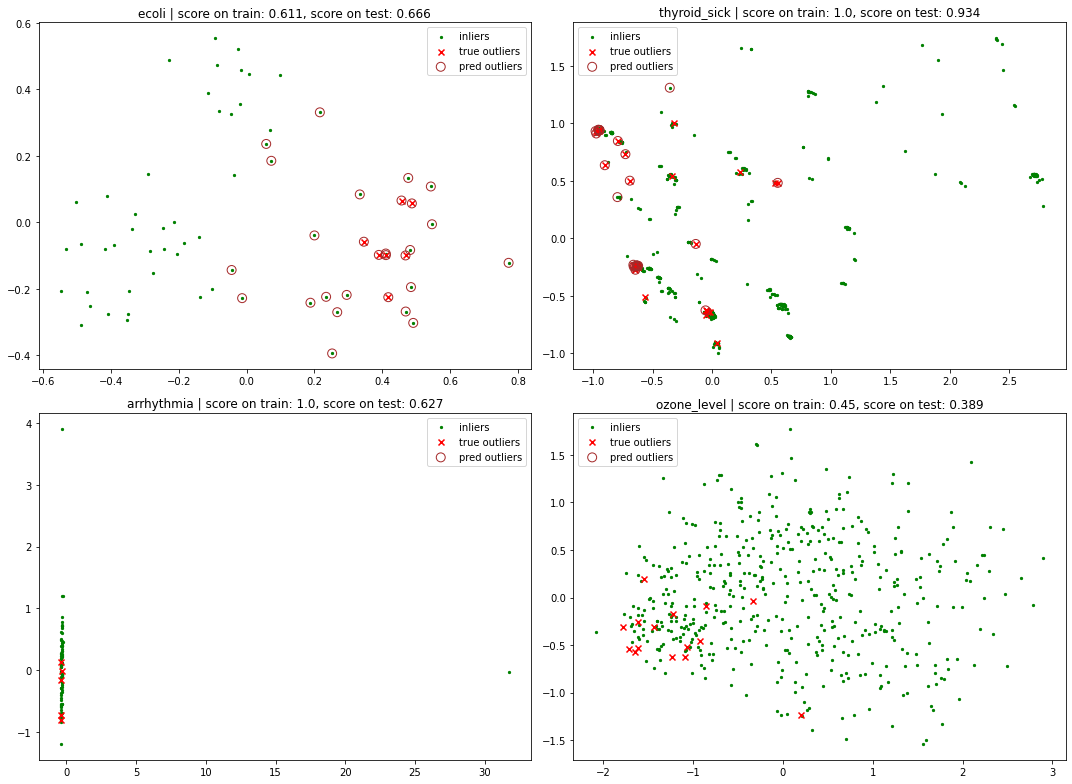

In [6]:
# Performance of the winners: visualization
# =========================================

winners_dict_naive = dict(tmp[tmp["rank"]==1][["dataset","model"]].values)

fig = plt.figure(figsize=(15,11))

for i,dataset in enumerate(DATASETS_LIST):
    data = fetch_datasets()[dataset]
    X = pd.DataFrame(data.data)
    y = pd.DataFrame(data.target, columns=["target"])

    # Data processing
    X.columns = [f"v{i}" for i in range(len(X.columns))]
    y["target"] = y["target"].map({-1:0, 1:1})

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

    # Scaling
    scaler = MinMaxScaler().fit(X_train)
    col_names = scaler.feature_names_in_

    X_train = pd.DataFrame(scaler.transform(X_train), columns=col_names, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=col_names, index=X_test.index)

    # Fitting and evaluating
    model = CLF_DICT[winners_dict_naive[dataset]]
    model.fit(X_train, y_train.values.ravel())

    y_scores_train = model.predict_proba(X_train)[:,1] 
    y_scores_test = model.predict_proba(X_test)[:,1]

    avg_precision_train = average_precision_score(y_train, y_scores_train, average="macro")
    avg_precision_test = average_precision_score(y_test, y_scores_test, average="macro")

    fig.add_subplot(2,2,i+1)
    plot_predictions(X_test, y_test, classifier=model)
    plt.title(f"{dataset} | score on train: {avg_precision_train.round(3)}, score on test: {avg_precision_test.round(3)}")

plt.tight_layout()
plt.show()

### 2. Beating the baseline: grid search approach

For each dataset in ```DATASETS_LIST``` 
- we find "the best" logistic regression, random forest, and naive bayes via grid search 
- we score the search using the average precision score
- finally, within these "best models" the one with the highest score will be the winner  

In [7]:
winners_dict_gs = {}
metrics_df = pd.DataFrame(columns=EVAL_METRICS, index=DATASETS_LIST)

pipeline = Pipeline([
    ("classifier", CLF_DICT["randforest"]),
])

c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


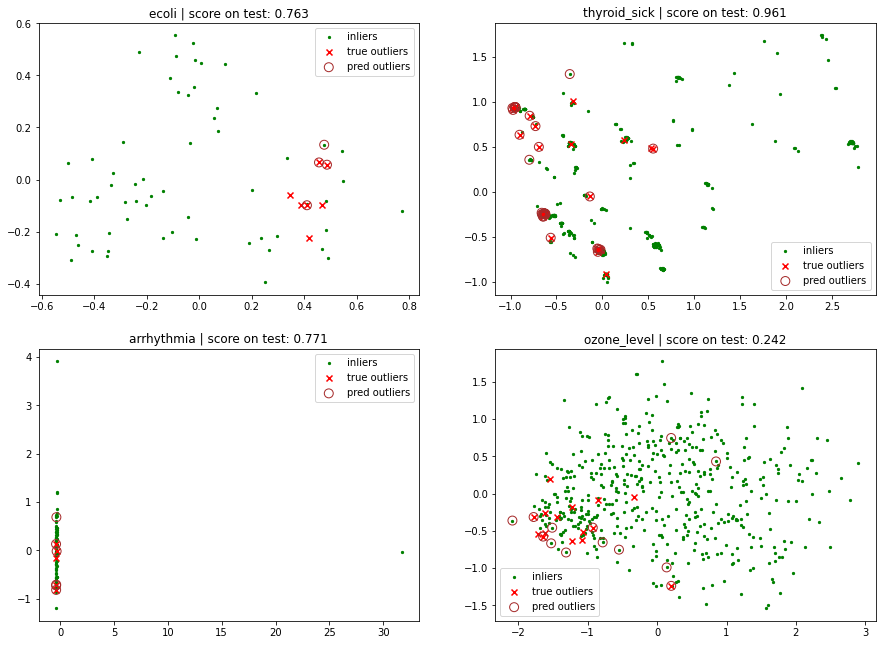

In [8]:
fig = plt.figure(figsize=(15,11))

for i,dataset in enumerate(DATASETS_LIST):

    # Loading data
    data = fetch_datasets()[dataset]
    X = pd.DataFrame(data.data)
    y = pd.DataFrame(data.target, columns=["target"])

    # Data processing
    X.columns = [f"v{i}" for i in range(len(X.columns))]
    y["target"] = y["target"].map({-1:0, 1:1})

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

    # Scaling
    scaler = MinMaxScaler().fit(X_train)
    col_names = scaler.feature_names_in_

    X_train = pd.DataFrame(scaler.transform(X_train), columns=col_names, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=col_names, index=X_test.index)

    # Grid search
    skf = StratifiedKFold(n_splits=5)
    folds = list(skf.split(X_train, y_train.values.ravel()))
    search = GridSearchCV(pipeline, PARAMS, cv=folds, n_jobs=-1, scoring="f1").fit(X_train, y_train.values.ravel())

    # Keeping the best model
    winners_dict_gs[dataset] = search.best_estimator_.steps[0][1]

    # Fitting best model 
    model = search.best_estimator_.steps[0][1]
    model.fit(X_train, y_train.values.ravel())

    # Computing metrics       
    metrics_dict = classification_metrics_report(X_test, y_test, model)
    metrics_df.loc[dataset] = metrics_dict
    metrics_df.loc[dataset,"model"] = type(model).__name__

    # Visualize predictions
    fig.add_subplot(2,2,i+1)
    plot_predictions(X_test, y_test, classifier=model)
    plt.title(f'{dataset} | score on test: {round(metrics_df.loc[dataset, "Average_Precision"], 3)}')

In [9]:
winners_dict_gs

{'ecoli': RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None,
                        random_state=404),
 'thyroid_sick': RandomForestClassifier(criterion='entropy', max_depth=7, max_features=None,
                        random_state=404),
 'arrhythmia': RandomForestClassifier(criterion='entropy', max_depth=2, max_features=None,
                        random_state=404),
 'ozone_level': LogisticRegression(C=0.001, max_iter=2500, penalty='none', random_state=404,
                    solver='saga')}

In [10]:
metrics_df.reset_index().rename(columns={"index":"dataset"})#.to_csv(f"{PATH_DATA_PERF}report-gsearch-supervised-{dataset}.csv")

,dataset,Accuracy,Precision,Recall,F1,ROC AUC,FN,TP,FP,TN,Average_Precision,model
0,ecoli,0.9265,0.8438,0.7061,0.7527,0.9672,4.0,3.0,1.0,60.0,0.7631,RandomForestClassifier
1,thyroid_sick,0.9881,0.9707,0.9225,0.9451,0.9869,7.0,39.0,2.0,707.0,0.9611,RandomForestClassifier
2,arrhythmia,0.967,0.8275,0.8884,0.8549,0.8907,1.0,4.0,2.0,84.0,0.771,RandomForestClassifier
3,ozone_level,0.9606,0.6427,0.6242,0.6327,0.9285,11.0,4.0,9.0,484.0,0.2422,LogisticRegression


### 3. Exploring improvements: resample techniques

### Undersampling

In [11]:
for dataset in DATASETS_LIST:

    metrics_df = pd.DataFrame(columns=EVAL_METRICS, index=list(UNDERSAMPLER_DICT.keys()))

    # Loading data
    data = fetch_datasets()[dataset]
    X = pd.DataFrame(data.data)
    y = pd.DataFrame(data.target, columns=["target"])

    # Data processing
    X.columns = [f"v{i}" for i in range(len(X.columns))]
    y["target"] = y["target"].map({-1:0, 1:1})

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

    # Scaling
    scaler = MinMaxScaler().fit(X_train)
    col_names = scaler.feature_names_in_

    X_train = pd.DataFrame(scaler.transform(X_train), columns=col_names, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=col_names, index=X_test.index)

    for name, undersampler in UNDERSAMPLER_DICT.items():
        model = make_pipeline(undersampler, winners_dict_gs[dataset])
        model.fit(X_train, y_train.values.ravel())
        metrics_dict = classification_metrics_report(X_test, y_test, model)
        metrics_df.loc[name] = metrics_dict

    metrics_df['dataset'] = [dataset]*len(UNDERSAMPLER_DICT)
    metrics_df.to_csv(f"{PATH_DATA_PERF}undersampling-{dataset}.csv")

c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: Use

In [12]:
results = pd.concat([pd.read_csv(PATH_DATA_PERF + f) for f in [f"undersampling-{d}.csv" for d in DATASETS_LIST]])
results.rename(columns={"Unnamed: 0":"method"},inplace=True)
results.sort_values(["dataset","Average_Precision"], ascending=[True,False])

tmp = results.sort_values(["dataset","Average_Precision"], ascending=[True,False])
tmp["rank"] = tmp.groupby("dataset").cumcount()+1
tmp[tmp["rank"]==1].drop(columns="rank")#.to_csv(f"{PATH_DATA_PERF}report-undersamp-supervised-{dataset}.csv")

,method,Accuracy,Precision,Recall,F1,ROC AUC,FN,TP,FP,TN,Average_Precision,dataset
2,tomek,0.9670,0.8275,0.8884,0.8549,0.8919,1.0,4.0,2.0,84.0,0.8110,arrhythmia
4,enn,0.8971,0.7500,0.9426,0.8029,0.9941,0.0,7.0,7.0,54.0,0.9379,ecoli
5,renn,0.9626,0.6863,0.7222,0.7025,0.9421,8.0,7.0,11.0,482.0,0.3316,ozone_level
2,tomek,0.9894,0.9720,0.9334,0.9517,0.9968,6.0,40.0,2.0,707.0,0.9644,thyroid_sick


In [13]:
winners_dict_undersamp = {
    'ecoli':UNDERSAMPLER_DICT["enn"],
    'thyroid_sick':UNDERSAMPLER_DICT["tomek"],
    'arrhythmia':UNDERSAMPLER_DICT["tomek"],
    'ozone_level':UNDERSAMPLER_DICT["renn"],
}

c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


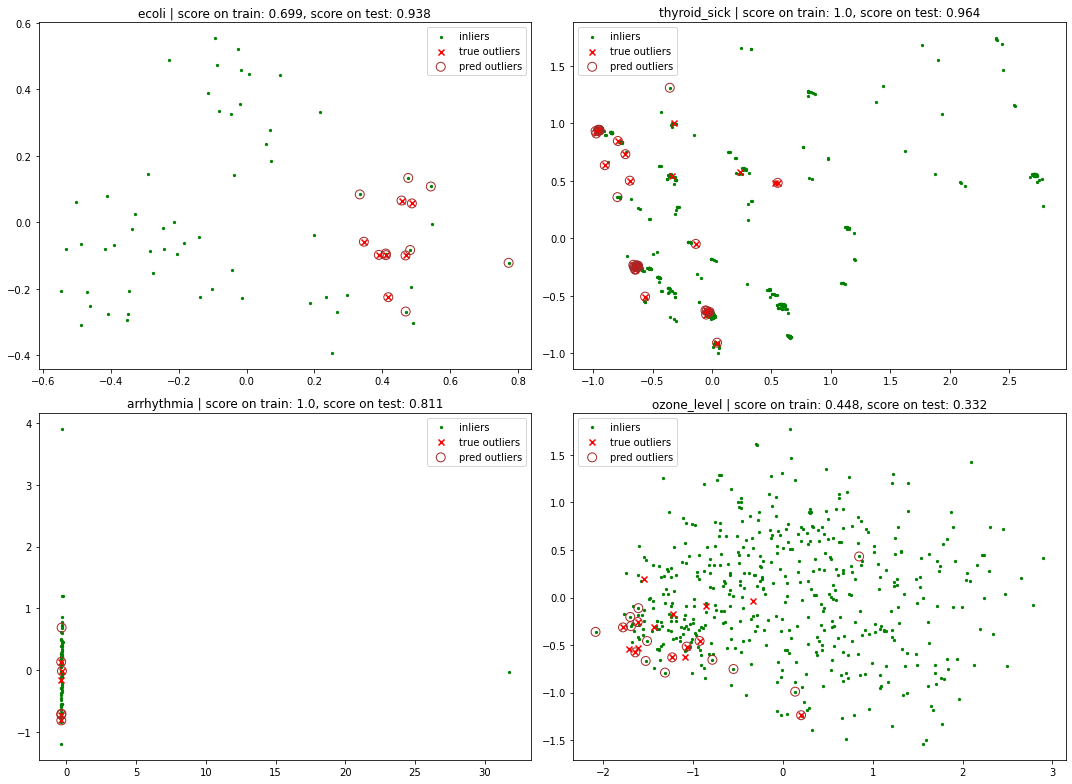

In [14]:
fig = plt.figure(figsize=(15,11))

for i,dataset in enumerate(DATASETS_LIST):

    # Loading data
    data = fetch_datasets()[dataset]
    X = pd.DataFrame(data.data)
    y = pd.DataFrame(data.target, columns=["target"])

    # Data processing
    X.columns = [f"v{i}" for i in range(len(X.columns))]
    y["target"] = y["target"].map({-1:0, 1:1})

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

    # Scaling
    scaler = MinMaxScaler().fit(X_train)
    col_names = scaler.feature_names_in_

    X_train = pd.DataFrame(scaler.transform(X_train), columns=col_names, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=col_names, index=X_test.index)

    model = make_pipeline(winners_dict_undersamp[dataset], winners_dict_gs[dataset])
    model.fit(X_train, y_train.values.ravel())

    y_scores_train = model.predict_proba(X_train)[:,1] 
    y_scores_test = model.predict_proba(X_test)[:,1]

    avg_precision_train = average_precision_score(y_train, y_scores_train, average="macro")
    avg_precision_test = average_precision_score(y_test, y_scores_test, average="macro")

    fig.add_subplot(2,2,i+1)
    plot_predictions(X_test, y_test, classifier=model)
    plt.title(f"{dataset} | score on train: {avg_precision_train.round(3)}, score on test: {avg_precision_test.round(3)}")

plt.tight_layout()
plt.show()

### Oversampling

In [15]:
for dataset in DATASETS_LIST:

    metrics_df = pd.DataFrame(columns=EVAL_METRICS, index=list(OVERSAMPLER_DICT.keys()))

    # Loading data
    data = fetch_datasets()[dataset]
    X = pd.DataFrame(data.data)
    y = pd.DataFrame(data.target, columns=["target"])

    # Data processing
    X.columns = [f"v{i}" for i in range(len(X.columns))]
    y["target"] = y["target"].map({-1:0, 1:1})

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

    # Scaling
    scaler = MinMaxScaler().fit(X_train)
    col_names = scaler.feature_names_in_

    X_train = pd.DataFrame(scaler.transform(X_train), columns=col_names, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=col_names, index=X_test.index)

    for name, oversampler in OVERSAMPLER_DICT.items():
        model = make_pipeline(oversampler, winners_dict_gs[dataset])
        model.fit(X_train, y_train.values.ravel())
        metrics_dict = classification_metrics_report(X_test, y_test, model)
        metrics_df.loc[name] = metrics_dict

    metrics_df['dataset'] = [dataset]*len(OVERSAMPLER_DICT)
    metrics_df.to_csv(f"{PATH_DATA_PERF}oversampling-{dataset}.csv")

c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: Use

In [16]:
results = pd.concat([pd.read_csv(PATH_DATA_PERF + f) for f in [f"oversampling-{d}.csv" for d in DATASETS_LIST]])
results.rename(columns={"Unnamed: 0":"method"},inplace=True)
results.sort_values(["dataset","Average_Precision"], ascending=[True,False])

tmp = results.sort_values(["dataset","Average_Precision"], ascending=[True,False])
tmp["rank"] = tmp.groupby("dataset").cumcount()+1

tmp[tmp["rank"]==1].drop(columns="rank")#.to_csv(f"{PATH_DATA_PERF}report-oversamp-supervised.csv")

,method,Accuracy,Precision,Recall,F1,ROC AUC,FN,TP,FP,TN,Average_Precision,dataset
1,smote,0.9560,0.7798,0.8826,0.8216,0.8930,1.0,4.0,3.0,83.0,0.8110,arrhythmia
0,random,0.9412,0.8762,0.7775,0.8172,0.9578,3.0,4.0,1.0,60.0,0.7898,ecoli
4,border2,0.8839,0.5848,0.8432,0.6130,0.9251,3.0,12.0,56.0,437.0,0.2706,ozone_level
3,border1,0.9841,0.9172,0.9509,0.9333,0.9720,4.0,42.0,8.0,701.0,0.9434,thyroid_sick


In [17]:
winners_dict_oversamp = {
    'ecoli':OVERSAMPLER_DICT["random"],
    'thyroid_sick':OVERSAMPLER_DICT["border1"],
    'arrhythmia':OVERSAMPLER_DICT["smote"],
    'ozone_level':OVERSAMPLER_DICT["border2"],
}

c:\Users\L03502619\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


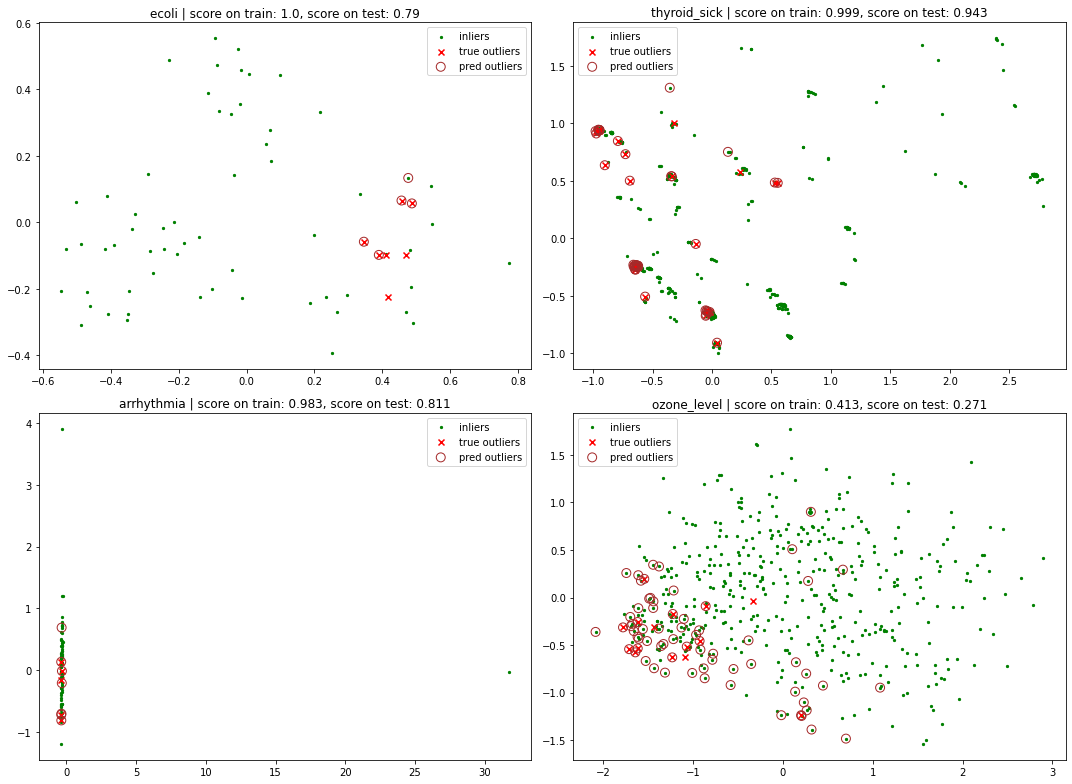

In [18]:
fig = plt.figure(figsize=(15,11))

for i,dataset in enumerate(DATASETS_LIST):

    # Loading data
    data = fetch_datasets()[dataset]
    X = pd.DataFrame(data.data)
    y = pd.DataFrame(data.target, columns=["target"])

    # Data processing
    X.columns = [f"v{i}" for i in range(len(X.columns))]
    y["target"] = y["target"].map({-1:0, 1:1})

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

    # Scaling
    scaler = MinMaxScaler().fit(X_train)
    col_names = scaler.feature_names_in_

    X_train = pd.DataFrame(scaler.transform(X_train), columns=col_names, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=col_names, index=X_test.index)

    model = make_pipeline(winners_dict_oversamp[dataset], winners_dict_gs[dataset])
    model.fit(X_train, y_train.values.ravel())

    y_scores_train = model.predict_proba(X_train)[:,1] 
    y_scores_test = model.predict_proba(X_test)[:,1]

    avg_precision_train = average_precision_score(y_train, y_scores_train, average="macro")
    avg_precision_test = average_precision_score(y_test, y_scores_test, average="macro")

    fig.add_subplot(2,2,i+1)
    plot_predictions(X_test, y_test, classifier=model)
    plt.title(f"{dataset} | score on train: {avg_precision_train.round(3)}, score on test: {avg_precision_test.round(3)}")

plt.tight_layout()
plt.show()

### References
- https://towardsdatascience.com/how-to-tune-multiple-ml-models-with-gridsearchcv-at-once-9fcebfcc6c23
- https://towardsdatascience.com/imbalanced-class-sizes-and-classification-models-a-cautionary-tale-part-2-cf371500d1b3
- https://towardsdatascience.com/advanced-pipelines-with-scikit-learn-4204bb71019b